# **Modelling and Evaluating**

## Objectives
* Train and validate a CNN-based classifier to distinguish healthy vs. powdery-mildew leaves.

## Inputs

* `input/datasets/cherry_leaf_dataset/cherry-leaves/train`
* `input/datasets/cherry_leaf_dataset/cherry-leaves/validation`
* `input/datasets/cherry_leaf_dataset/cherry-leaves/test`
* `image_shape = (256, 256, 3)` embedding from Notebook 2

## Outputs

* Data‐loading & augmentation pipeline  
* Model architecture definition and compilation  
* Trained model saved to `models/cherry_leaf_classifier.h5`  
* Learning‐curve plot (`figures/learning_curves.png`)  
* Confusion‐matrix plot on test set (`figures/confusion_matrix.png`)  
* Classification report (printed and saved as `reports/classification_report.txt`)  
* Sample prediction function and example inference on a random image

---

## Imports

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from matplotlib.image import imread
import random

# Change working directory

* We update the working directory as in the previous notebooks.

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-MildewDetection/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-MildewDetection'

## Set Train, Validation and Test Paths

In [6]:
my_data_dir = 'input/datasets/cherry_leaf_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [7]:
from pathlib import Path

# versioning & output directory
version = "v1"
base_out = Path("outputs") / version
figures_out = base_out / "figures"

# create folders if they don’t exist
figures_out.mkdir(parents=True, exist_ok=True)

print(f"Saving all figures into: {figures_out}")

Saving all figures into: outputs/v1/figures


## Set Label Names

In [8]:
labels = sorted(
    [p.name for p in Path(train_path).iterdir() if p.is_dir()]
)
print("Labels:", labels)

Labels: ['healthy', 'powdery_mildew']


## Set Image Shape

Shape aligned with the distribution identified in Notebook 2.

In [9]:
image_shape = (256, 256, 3)
print("Using image_shape:", image_shape)

Using image_shape: (256, 256, 3)


## Set Initial Hyperparameters

In [9]:
batch_size = 32
learning_rate = 0.001
epochs = 10

print(f"batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}")

batch_size=32, learning_rate=0.001, epochs=10


---

## Data Preparation & Augmentation

- Rescale all images from [0–255] to [0–1].  
- Augment training images with random transforms (rotation, zoom, flip) to reduce overfitting.  
- Batch and shuffle the data for efficient training.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmenting generator
train_gen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Non-augmenting generators for validation/test
test_val_gen = ImageDataGenerator(rescale=1/255.0)

# Create iterators
train_iterator = train_gen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_iterator = test_val_gen.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_iterator = test_val_gen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


2025-04-27 15:10:54.088025: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 15:10:54.127814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


#### Augmentation Preview

Below we generate and display a small grid of augmented training samples so we can verify that rotation, shifts, zooms and flips are being applied correctly.

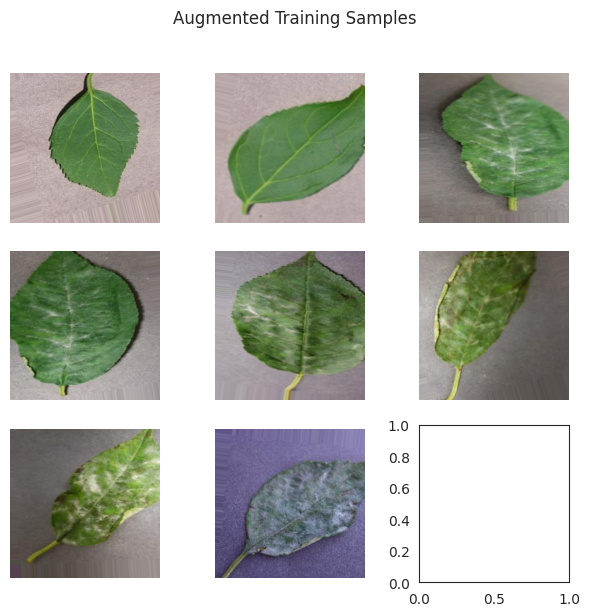

In [11]:
# Takes one batch of augmented images
images, labels_ = next(train_iterator)

# Displays 3×3 grid of the first 9 augmented samples
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for img, ax in zip(images[:9], axes.flatten()):
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("Augmented Training Samples", y=1.02)
plt.tight_layout()
plt.savefig(figures_out/'augmented_samples.png')
plt.show()

#### Data Prep Conclusion

We’ve established our data pipelines: 
- Training images are rescaled and augmented to improve generalisation.  
- Validation/Test images are only rescaled to ensure fair performance evaluation.  

These iterators feed directly into model training and evaluation.

---

## Model Definition & Compilation

In this CRISP-DM Modeling phase, we’ll translate our business requirement (“predict healthy vs. powdery-mildew leaf”) into a trainable CNN pipeline. We’ll:

- Define a simple convolutional network with batch-normalization and dropout for robustness.  
- Compile it with a binary cross-entropy loss (as the business requirement is a two-class task) and track accuracy.  
- Document key hyperparameters so we can revisit them during tuning.

In [12]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Flatten, Dense, Dropout)
from tensorflow.keras.optimizers import Adam

def build_model(image_shape, learning_rate=1e-3, dropout_rate=0.5):
    """Creates and compiles a CNN for binary classification of cherry-leaf images.
    
    Args:
      image_shape (tuple): e.g. (256, 256, 3)
      learning_rate (float): Adam optimizer step size
      dropout_rate (float): Dropout fraction for the dense layer
    
    Returns:
      tf.keras.Model: compiled CNN ready for training
    """
    model = Sequential([
        Input(shape=image_shape),

        # Block 1
        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Block 2
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Block 3
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Classification head
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate), # regularization to reduce overfitting
        Dense(1, activation='sigmoid') # single output for binary classification
    ])

    # Compile with documented hyperparameters
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


#### Model Definition Conclusion

We’ve defined and compiled a CNN suited to our binary classification task, with clear hyperparameter variables for future tuning. The model summary confirms the layer shapes and parameter counts. 

Next, we’ll proceed to training, where we’ll fit this model to our augmented data, monitor loss/accuracy over epochs, and assess convergence.

---

## Model Training & Learning Curves

Now that our model is defined and compiled, we’ll train it on the augmented data and monitor its performance over time. This will give us insight into convergence behaviour for later tuning.

### **Run 1**

In [13]:
# Train the model
history = model.fit(
    train_iterator,
    validation_data=val_iterator,
    epochs=epochs
)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.9503 - loss: 1.6928 - val_accuracy: 0.5000 - val_loss: 175.2137
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9850 - loss: 1.4090 - val_accuracy: 0.5000 - val_loss: 355.3348
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.9940 - loss: 0.8353 - val_accuracy: 0.5024 - val_loss: 398.3617
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.9869 - loss: 1.2012 - val_accuracy: 0.5000 - val_loss: 622.5397
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9895 - loss: 1.1400 - val_accuracy: 0.9643 - val_loss: 3.8380
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9969 - loss: 0.3968 - val_accuracy: 0.9833 - val_loss: 1.0431
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9924 - loss: 0.4206 - val_accuracy: 0.5000 - val_loss: 873.7693
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9958 - loss: 0.6159 - val_accuracy: 

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,519,109 (169.83 MB)

 Trainable params: 14,839,553 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 29,679,108 (113.22 MB)

## Run 1 Diagnostics & Hyperparameter Tuning

#### Run 1 Observations
- Validation accuracy and loss oscillated wildly (50% → 100% → 50% → 100%), indicating unstable convergence.  
- Likely causes:
  1. Learning rate too high.  
  2. No Early Stopping, so the model kept “blowing up” after finding a good region.  

To address this, in **Run 2** we will:
- Lower the learning rate to 1e-4 for smaller, steadier updates.  
- Add an Early Stopping callback on `val_loss` with `patience=2` and `restore_best_weights=True`.

### **Run 2**

In [13]:
# Revised hyperparameters for Run 2
batch_size = 8    # lowered from 32 to reduce memory footprint (Run 2 crashed twice initially)
learning_rate = 1e-4
epochs = 10

print(f"batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}")

batch_size=8, learning_rate=0.0001, epochs=10


In [14]:
train_iterator = train_gen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_iterator = test_val_gen.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_iterator = test_val_gen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


Found 844 images belonging to 2 classes.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Rebuild model with lower learning rate
model = build_model(
    image_shape=image_shape,
    learning_rate=0.0001,
    dropout_rate=0.5
)

# Inspect architecture
model.summary()

# Set up EarlyStopping
es = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Retrain (Run 2) using the same iterators
history_2 = model.fit(
    train_iterator,
    validation_data=val_iterator,
    epochs=epochs,
    callbacks=[es]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,001 (56.61 MB)

 Trainable params: 14,839,553 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 259s 696ms/step - accuracy: 0.9471 - loss: 0.4862 - val_accuracy: 0.6905 - val_loss: 5.7672
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 256s 696ms/step - accuracy: 0.9841 - loss: 0.1043 - val_accuracy: 0.9833 - val_loss: 0.1105
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 257s 698ms/step - accuracy: 0.9812 - loss: 0.1924 - val_accuracy: 1.0000 - val_loss: 6.8430e-08
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 255s 694ms/step - accuracy: 0.9930 - loss: 0.0738 - val_accuracy: 1.0000 - val_loss: 3.2948e-07
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 256s 695ms/step - accuracy: 0.9974 - loss: 0.0235 - val_accuracy: 1.0000 - val_loss: 1.1993e-08
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 256s 695ms/step - accuracy: 0.9970 - loss: 0.0174 - val_accuracy: 0.9976 - val_loss: 0.0056
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 256s 696ms/step - accuracy: 0.9958 - loss: 0.0323 - val_accuracy: 1.0000 - val_loss: 8.1180e-04


#### Run 2 Results Summary

- Stable convergence: Validation accuracy rose steadily from 69.1% in epoch 1 to over 98% by epoch 2, reaching 100% by epoch 3.  
- Rapid fit: By epoch 5, the model achieved 100% validation accuracy with a minuscule validation loss of 1.2 × 10⁻⁸.  
- EarlyStopping: With `patience=2`, training halted at epoch 7 and restored the best weights (from epoch 5), preventing further over‐fitting.  
- **Final metrics (best epoch):**  
  - Train acc ≈ 99.74%  
  - Val acc = 100.00%  
  - Val loss ≈ 1.2 × 10⁻⁸
- Overfitting note: Perfect validation performance suggests the model has effectively memorised the validation set. We may need stronger augmentation or regularization in future iterations to improve generalization.

These results give us a highly accurate classifier on our current data splits; next we’ll generate the corresponding learning‐curve plots before moving on to test‐set evaluation.  